<a href="https://colab.research.google.com/github/EloperElf/Discord-Bot/blob/main/Mental_health_chatbot_ext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import random
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment', None)

In [2]:
data=pd.read_csv("/content/Mental_Health_FAQ.csv",nrows=20)

In [ ]:
data.head()

,Question_ID,Questions,Answers
0,1590140,What does it mean to have a mental illness?,Mental illnesses are health conditions that di...
1,2110618,Who does mental illness affect?,It is estimated that mental illness affects 1 ...
2,6361820,What causes mental illness?,It is estimated that mental illness affects 1 ...
3,9434130,What are some of the warning signs of mental i...,Symptoms of mental health disorders vary depen...
4,7657263,Can people with mental illness recover?,"When healing from mental illness, early identi..."


Data Pre-processing

In [3]:
for i in range(data.shape[0]):
  data['Answers'][i]=re.sub(r'\n', ' ',data['Answers'][i])
  data['Answers'][i]=re.sub('\(', '',data['Answers'][i]) 
  data['Answers'][i]=re.sub(r'\)', '',data['Answers'][i]) 
  data['Answers'][i]=re.sub(r',', '',data['Answers'][i]) 
  data['Answers'][i]=re.sub(r'-', '',data['Answers'][i])
  data['Answers'][i]=re.sub(r'/', '',data['Answers'][i])  
  data['Answers'][i]=re.sub(r'/', '',data['Answers'][i])

In [4]:
pairs=[]

for i in range(data.shape[0]):
  pairs.append(((data['Questions'][i]),data['Answers'][i]))

In [5]:
pairs                                     # questions

[('What does it mean to have a mental illness?',
  'Mental illnesses are health conditions that disrupt a personâ€™s thoughts emotions relationships and daily functioning. They are associated with distress and diminished capacity to engage in the ordinary activities of daily life. Mental illnesses fall along a continuum of severity: some are fairly mild and only interfere with some aspects of life such as certain phobias. On the other end of the spectrum lie serious mental illnesses which result in major functional impairment and interference with daily life. These include such disorders as major depression schizophrenia and bipolar disorder and may require that the person receives care in a hospital. It is important to know that mental illnesses are medical conditions that have nothing to do with a personâ€™s character intelligence or willpower. Just as diabetes is a disorder of the pancreas mental illness is a medical condition due to the brainâ€™s biology. Similarly to how one would

In [6]:
input_docs = []
target_docs = []
input_tokens = set()
target_tokens = set()

for line in pairs:

  input_doc, target_doc = line[0], line[1]

  # Appending each input sentence to input_docs
  input_docs.append(input_doc)

  # Splitting words from punctuation  
  target_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", target_doc))

  # Redefine target_doc below and append it to target_docs
  target_doc = '<START> ' + target_doc + ' <END>'

  target_docs.append(target_doc)

  for token in re.findall(r"[\w']+|[^\s\w]", input_doc):
    if token not in input_tokens:
      input_tokens.add(token)
  for token in target_doc.split():
    if token not in target_tokens:
      target_tokens.add(token)

input_tokens = sorted(list(input_tokens))  # contains all words of input_docs
target_tokens = sorted(list(target_tokens))
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)

In [7]:
target_docs

['<START> Mental illnesses are health conditions that disrupt a personâ € ™ s thoughts emotions relationships and daily functioning . They are associated with distress and diminished capacity to engage in the ordinary activities of daily life . Mental illnesses fall along a continuum of severity : some are fairly mild and only interfere with some aspects of life such as certain phobias . On the other end of the spectrum lie serious mental illnesses which result in major functional impairment and interference with daily life . These include such disorders as major depression schizophrenia and bipolar disorder and may require that the person receives care in a hospital . It is important to know that mental illnesses are medical conditions that have nothing to do with a personâ € ™ s character intelligence or willpower . Just as diabetes is a disorder of the pancreas mental illness is a medical condition due to the brainâ € ™ s biology . Similarly to how one would treat diabetes with medi

In [8]:
input_features_dict = dict([(token, i) for i, token in enumerate(input_tokens)])
target_features_dict = dict([(token, i) for i, token in enumerate(target_tokens)])

reverse_input_features_dict = dict((i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict((i, token) for token, i in target_features_dict.items())

In [9]:
input_features_dict

{'"': 0,
 ',': 1,
 '?': 2,
 'Can': 3,
 'How': 4,
 'I': 5,
 'If': 6,
 'What': 7,
 'Where': 8,
 'Who': 9,
 'a': 10,
 'about': 11,
 'affect': 12,
 'after': 13,
 'am': 14,
 'and': 15,
 'appears': 16,
 'are': 17,
 'available': 18,
 'become': 19,
 'before': 20,
 'better': 21,
 'between': 22,
 'can': 23,
 'causes': 24,
 'child': 25,
 'cured': 26,
 'difference': 27,
 'different': 28,
 'disorder': 29,
 'do': 30,
 'does': 31,
 'else': 32,
 'feel': 33,
 'find': 34,
 'for': 35,
 'get': 36,
 'go': 37,
 'group': 38,
 'have': 39,
 'health': 40,
 'help': 41,
 'if': 42,
 'illness': 43,
 'in': 44,
 'involved': 45,
 'is': 46,
 'it': 47,
 'know': 48,
 'learn': 49,
 'mean': 50,
 'medication': 51,
 'mental': 52,
 'my': 53,
 'myself': 54,
 'need': 55,
 'new': 56,
 'of': 57,
 'options': 58,
 'or': 59,
 'paying': 60,
 'people': 61,
 'professional': 62,
 'professionals': 63,
 'recover': 64,
 'right': 65,
 'should': 66,
 'signs': 67,
 'some': 68,
 'someone': 69,
 'starting': 70,
 'stop': 71,
 'support': 72,
 'sy

**Encoder-Decoder model**


In [10]:
max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in input_docs])
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in target_docs])

encoder_input_data = np.zeros(
    (len(input_docs), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
for line, (input_doc, target_doc) in enumerate(zip(input_docs, target_docs)):
    for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
        #Assign 1. for the current line, timestep, & word in encoder_input_data
        encoder_input_data[line, timestep, input_features_dict[token]] = 1.
    
    for timestep, token in enumerate(target_doc.split()):
        decoder_input_data[line, timestep, target_features_dict[token]] = 1.
        if timestep > 0:
            decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1.

In [ ]:
encoder_input_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [11]:
decoder_target_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

**Training**

In [12]:
from tensorflow import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model  
dimensionality = 256 # Dimensionality 
batch_size = 10   # The batch size and number of epochs
epochs = 500 

#Encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(dimensionality, return_state=True)
encoder_outputs, state_hidden, state_cell = encoder_lstm(encoder_inputs)
encoder_states = [state_hidden, state_cell]

#Decoder
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(dimensionality, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_hidden, decoder_state_cell = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [13]:
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs) # Compiling

In [14]:
training_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 85)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 693)]  0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        350208      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

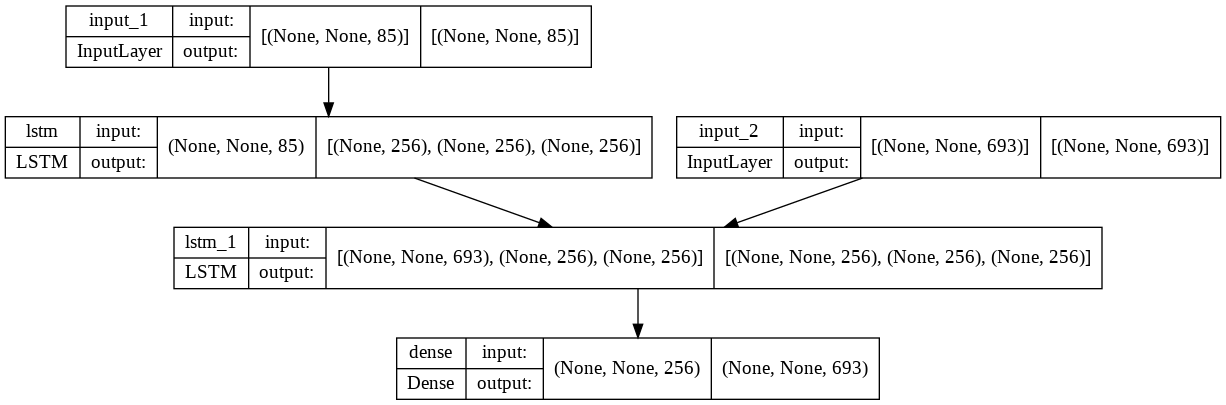

In [15]:
from keras.utils.vis_utils import plot_model
plot_model(training_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)   # plot model

In [16]:
training_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'], sample_weight_mode='temporal')#Training
history1=training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size = batch_size, epochs = epochs, validation_split = 0.2)
training_model.save('training_model.h5')

Epoch 1/500
2/2 [==============================] - 7s 2s/step - loss: 3.9023 - accuracy: 0.1124 - val_loss: 1.2140 - val_accuracy: 0.0120
Epoch 2/500
2/2 [==============================] - 2s 853ms/step - loss: 3.8004 - accuracy: 0.0281 - val_loss: 1.0811 - val_accuracy: 0.0100
Epoch 3/500
2/2 [==============================] - 2s 867ms/step - loss: 3.4739 - accuracy: 0.0228 - val_loss: 1.0800 - val_accuracy: 0.0070
Epoch 4/500
2/2 [==============================] - 2s 850ms/step - loss: 3.4176 - accuracy: 0.0168 - val_loss: 1.0790 - val_accuracy: 0.0100
Epoch 5/500
2/2 [==============================] - 2s 973ms/step - loss: 3.3939 - accuracy: 0.0221 - val_loss: 1.0698 - val_accuracy: 0.0110
Epoch 6/500
2/2 [==============================] - 3s 1s/step - loss: 3.3818 - accuracy: 0.0248 - val_loss: 1.0712 - val_accuracy: 0.0120
Epoch 7/500
2/2 [==============================] - 3s 1s/step - loss: 3.3873 - accuracy: 0.0284 - val_loss: 1.0724 - val_accuracy: 0.0110
Epoch 8/500
2/2 [=====

In [17]:
from keras.models import load_model
training_model = load_model('training_model.h5')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

In [18]:
latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]

In [19]:
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)

In [20]:
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [21]:
from keras.models import load_model
training_model = load_model('training_model.h5')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def decode_response(test_input):
    #Getting the output states to pass into the decoder
    states_value = encoder_model.predict(test_input)
    
    #Generating empty target sequence of length 1
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    
    #Setting the first token of target sequence with the start token
    target_seq[0, 0, target_features_dict['<START>']] = 1.
    
    #A variable to store our response word by word
    decoded_sentence = ''
    
    stop_condition = False
    while not stop_condition:
          #Predicting output tokens with probabilities and states
          output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)
          
          #Choosing the one with highest probability
          sampled_token_index = np.argmax(output_tokens[0, -1, :])
          sampled_token = reverse_target_features_dict[sampled_token_index]
          decoded_sentence += " " + sampled_token
          
          #Stop if hit max length or found the stop token
          if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
          
          #Update the target sequence
          target_seq = np.zeros((1, 1, num_decoder_tokens))
          target_seq[0, 0, sampled_token_index] = 1.
          
          #Update states          
          states_value = [hidden_state, cell_state]
    return decoded_sentence

In [24]:
class ChatBot:
  negative_responses = ("no", "nope", "nah", "naw", "not a chance", "sorry")
  exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop")
  
  #Method to start the conversation
  def start_chat(self):
    user_response = input("Hi, I'm NYX! your dear consultant to help you you out. AMA!\n")
    
    if user_response in self.negative_responses:
      print("Ok, have a great day!")
      return
    self.chat(user_response)
  
  #Method to handle the conversation
  def chat(self, reply):
    while not self.make_exit(reply):
      reply = input(self.generate_response(reply)+"\n")
    
  #Method to convert user input into a matrix
  def string_to_matrix(self, user_input):
    tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
    user_input_matrix = np.zeros(
      (1, max_encoder_seq_length, num_encoder_tokens),
      dtype='float32')
    for timestep, token in enumerate(tokens):
      if token in input_features_dict:
        user_input_matrix[0, timestep, input_features_dict[token]] = 1.
    return user_input_matrix
  
  #Method that will create a response using seq2seq model we built
  def generate_response(self, user_input):
    input_matrix = self.string_to_matrix(user_input)
    chatbot_response = decode_response(input_matrix)
    #Remove <START> and <END> tokens from chatbot_response
    chatbot_response = chatbot_response.replace("<START>",'')
    chatbot_response = chatbot_response.replace("<END>",'')
    return chatbot_response
  
  #Method to check for exit commands
  def make_exit(self, reply):
    for exit_command in self.exit_commands:
      if exit_command in reply:
        print("Ok, have a great day!")
        return True
    return False
  
chatbot = ChatBot()

**Demo**

In [25]:
chatbot.start_chat()

Hi, I'm NYX! your dear consultant to help you you out. AMA!
quit
Ok, have a great day!
